# <font color=blue> 기계학습 기초  7/8장: 분류기 (Logistic Regression)</font>
###  Machine Learning and Bioinformatics (MLBI) Lab @ DKU, 2020.07.04 <br>

In [1]:
import math
import numpy as np
import pandas as pd
from sklearn.datasets import load_iris, load_breast_cancer, load_digits
import sklearn.linear_model as lm
import sklearn.svm as svm
import sklearn.model_selection as mod_sel
import sklearn.metrics as met
from sklearn.manifold import TSNE
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

In [2]:
from matplotlib import cm

## Function to draw UMAP plot conveniently
def draw_scatter(pnt_2d, y, Title = None):
    C_map = cm.get_cmap('Spectral', 256)  # 'viridis'
    
    plt.figure(num=None, figsize=(16, 16), dpi=80, facecolor='w', edgecolor='k')

    ## Under the original label
    plt.subplot(2,2,1)
    scatters = []      
    z = y
    y_label = list(set(z))
    nl = len(y_label)-1
    for k, lbl in enumerate(y_label):
        n = y_label[k]
        scatters.append(plt.scatter(pnt_2d[z==n, 0], pnt_2d[z==n, 1], \
                                    color=C_map(k/nl), # marker=markers[k], \
                                    label=lbl, s = 4))

    plt.legend( tuple(scatters),
                tuple(y_label),
                scatterpoints=1,
                loc='upper right',
                ncol=1, # len(scatters),                                                                                                 
                fontsize=10)
    plt.xlabel('UC 1')
    plt.ylabel('UC 2')
    if Title is not None: 
        plt.title(Title, fontsize=11)
    plt.grid()


## 0. 필요한 파일 업로드 (colab 사용시 필요)

In [3]:
# from google.colab import files
# files.upload()

In [4]:
# !ls

## 1. 분류를 위한 전처리


#### (1) 전처리 - csv 파일 불러와서 열기

#### (2) 특징 벡터와 목표값 설정

#### (3) 분류기 생성

#### 점수 데이터

In [3]:
## (1) load data
file_name = 'scores.csv'
df = pd.read_csv(file_name)
print("Data size (n_sample,n_features): ",end='')
print(df.shape)

## (2) Set feature vector and target values
X = df.iloc[:,1:4] 
y = df.Group
label = list(set(y))

print(X.shape)
print('Target names: ', label)

Data size (n_sample,n_features): (100, 4)
(100, 3)
Target names:  ['B', 'A']


#### 유전자 발현량 데이터

In [17]:
## (1) load data
file_name = 'cancer_gene_exp.csv'
df = pd.read_csv(file_name,index_col=0)
print("Data size (n_sample,n_features): ",end='')
print(df.shape)

## Set feature vector and target values
X = df.iloc[:,1:]
y = df.Tumor_type
label = list(set(y))

print(X.shape)
print('Target names: ', label)

Data size (n_sample,n_features): (1655, 101)
(1655, 100)
Target names:  ['PCPG', 'COAD', 'CESC', 'THCA', 'ESCA', 'LUAD', 'THYM', 'UCEC', 'SARC']


#### 숫자 이미지 데이터 (8x8 -> 64x1)

In [40]:
## (1) load data
digits = load_digits()

## Set feature vector and target values
X = digits.data 
y = digits.target
label = list(set(y))

print(X.shape)
print('Target names: ', label)

(1797, 64)
Target names:  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]


#### tSNE을 이용한 데이터 확인

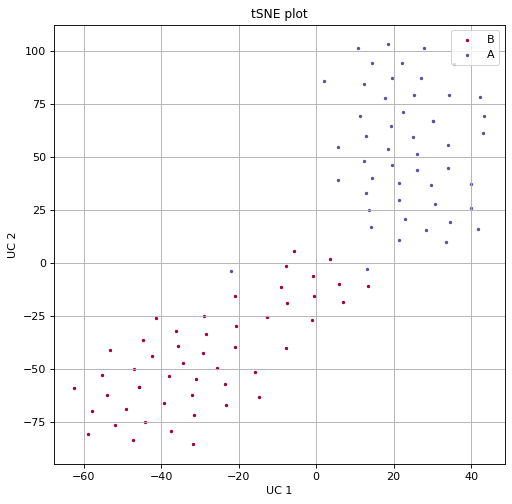

In [5]:
X_2d = TSNE(learning_rate=300, init='pca').fit_transform(X)

draw_scatter( X_2d, y, 'tSNE plot' )

In [6]:
X.shape

(100, 3)

#### (3) Create linear classifier and set its hyper parameters 

In [18]:
#########################################################
## (3) Set classifier and its parameters to use

classifier = lm.LogisticRegression( multi_class = 'multinomial', solver = 'lbfgs', max_iter = 2000)

### (Binary) Logistic regression with $l_1$ and $l_2$ penalty
Source: https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression

#### Model (logistic sigmoid function): $$ \hat{p}_1 = s\left({\bf{x}}^T_i {\boldsymbol{\theta}} + c \right) = \frac{1}{1 + e^{ - \left( {\bf{x}}^T_i {\boldsymbol{\theta}} + c \right)}} = Pr\{ {\bf{x}}_i {\text{ belongs to class 1}} \}$$
#### Cost to minimize (negative log-likelihood): $$ \min_{{\boldsymbol{\theta}},c} C \sum^{n}_{i=1} \log \left( 1 + \exp ^{ (1-2y_i) \left( {\bf x}^T_i {\boldsymbol{\theta}} + c \right)} \right) + \frac{1-\rho}{2} {\boldsymbol{\theta}}^T{\boldsymbol{\theta}} + \rho \| {\boldsymbol{\theta}} \|_1 $$
where
1. $C$ controls the relative weight between RSS (1st term) and penaties (2nd and 3rd terms). 
2. $\rho$ controls the relative weight between $l_1$ and $l_2$ penalty. $\rho = 1$ corresponds to LASSO while $\rho=0$ to Ridge.
3. $C \rightarrow \infty $ means no penalty.

<div>
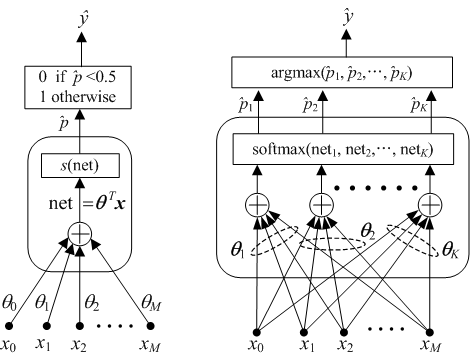
</div>

### (Multinomial) Logistic regression with $l_1$ and $l_2$ penalty


#### Model (softmax function): $$ S_{j}\left( {{\Theta}}^T {\bf x}_i + {\bf{c}} \right) = \frac{e^{ - \left( {\bf x}^T_i {\boldsymbol{\theta}}_{j} + c_j \right)}}{\sum^{K}_{k=1} e^{ - \left( {\bf{x}}^T_i {\boldsymbol{\theta}}_{k} + c_k \right)}} = Pr\{ {\bf{x}}_i {\text{ belongs to class }} j \}$$
#### Cost to minimize (negative log-likelihood): $$ \min_{{{\bf \Theta}, {\bf{c}}}} - C \sum^{n}_{i=1} \log S_{y_i}\left( {\bf \Theta}^T {\bf x}_i + {\bf{c}} \right) + \frac{1-\rho}{2} \| {\bf \Theta} \|^2_F + \rho \| {\bf \Theta} \|_{21} $$
where $S_y(\cdot)$ is soft-max function, ${\bf \Theta}$ is $M \times K$ parameter matrix and $ {\bf{c}}$ is $K \times 1$ intercept vector.

Function description: https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html


## 2. 학습 및 평가 절차 (basic)
$ $
<div>
    
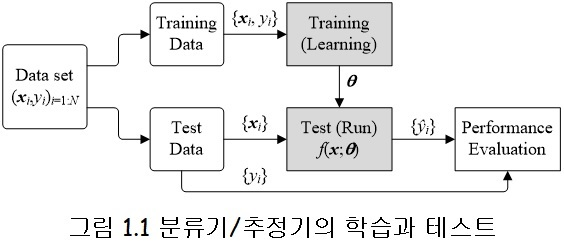
</div>

#### (1) 데이터를 학습데이터와 테스트 데이터로 분리
https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html

#### (2) 학습 수행(fit)


In [19]:
#########################################################
## (1) Claasification example : Naive implementation

## (1) Divide data for traning (70%) and test (30%)
X_train, X_test, y_train, y_test = mod_sel.train_test_split(X, y, test_size=0.3, random_state=5)

## (2) Fit SVM to the data, X_train and y_train
classifier.fit(X_train,y_train)


LogisticRegression(max_iter=2000, multi_class='multinomial')

#### (3) 테스트 수행 (predict)

#### (4) 성능/결과 확인 

In [20]:
## (3) Performance test
y_pred = classifier.predict(X_test)

## (4) Check performance
## For test data
accuracy = 100*sum(y_test==y_pred)/len(y_test)

## For training data
y_pred_train = classifier.predict(X_train)
accuracy_train = 100*sum(y_train==y_pred_train)/len(y_train)

print( "Accuracy(Naive) = %f, %f" % (round(accuracy,2), round(accuracy_train,2)) )

Accuracy(Naive) = 91.550000, 100.000000


#### Checking out probability 

In [21]:
## (6) Get class probability (belief)
y_prob = classifier.predict_proba(X_test)

df_y_prob = pd.DataFrame(y_prob)
df_y_prob['y_pred'] = y_pred
df_y_prob

,0,1,2,3,4,5,6,7,8,y_pred
0,9.999496e-01,4.729450e-07,6.601041e-07,3.146271e-07,1.179402e-08,2.105230e-05,1.184644e-07,4.429971e-07,2.734438e-05,CESC
1,2.576340e-07,9.035757e-01,9.641922e-02,4.065711e-08,6.431065e-08,1.442618e-07,1.223826e-07,3.025223e-06,1.399600e-06,COAD
2,2.565642e-08,3.136607e-06,2.129923e-05,1.683705e-08,4.643268e-08,9.998115e-01,7.570362e-07,5.787003e-07,1.626843e-04,SARC
3,4.992477e-02,9.599025e-03,9.282985e-01,8.868653e-04,9.287326e-06,1.104915e-02,1.198248e-04,1.066303e-04,5.998111e-06,ESCA
4,2.138708e-03,3.178758e-04,9.973455e-01,1.296269e-04,4.794641e-07,4.092608e-05,1.720764e-05,9.560534e-06,1.602428e-07,ESCA
...,...,...,...,...,...,...,...,...,...,...
492,5.354144e-01,2.914354e-06,7.085347e-03,3.875300e-04,6.920955e-05,4.562189e-01,1.403336e-06,1.891429e-04,6.312134e-04,CESC
493,1.068741e-03,2.551790e-05,3.609231e-07,9.982192e-01,3.119683e-08,7.518336e-07,5.164735e-04,1.687558e-04,1.245464e-07,LUAD
494,4.034270e-01,1.217097e-04,1.530476e-02,6.052072e-07,6.928493e-07,5.810401e-01,1.379928e-05,6.265572e-05,2.870934e-05,SARC
495,8.252763e-04,4.679337e-13,3.403860e-12,7.076963e-12,8.116301e-11,2.747571e-06,7.438270e-09,2.803573e-09,9.991720e-01,UCEC


 #### 학습을 통해 획득한 최적 파라미터 확인

In [22]:
print( "theta_0 (intercept) = ", classifier.intercept_ )

theta_0 (intercept) =  [ 5.09230247  6.44596388  3.72857759  1.17327029 -6.13823466  3.13476423
 -4.60947341 -3.43537995 -5.39179044]


In [23]:
print( "theta[1:M] = " )
print( classifier.coef_ )

theta[1:M] = 
[[ 8.11236344e-02 -4.03874166e-01  2.65683752e-01 -3.54826947e-01
  -4.36484420e-01  1.58608662e-01 -3.61698811e-01 -5.03257961e-02
  -2.25983774e-01  1.55556220e-01  1.47043465e-01  2.77774510e-01
  -2.07514593e-01 -1.47783852e-01 -4.09708370e-01 -7.66686728e-02
   9.29963417e-02  1.36507073e-01 -4.35686213e-01 -5.20301147e-01
  -2.69120299e-01  1.76429042e-01 -7.16573957e-01 -2.04076650e-01
  -3.24311363e-01 -3.93916826e-01  4.58278372e-01  6.75827146e-02
   1.49341052e-01  5.65448851e-01 -3.00528907e-02  2.12561742e-02
  -1.11586560e-02 -2.79512865e-01 -6.96065392e-02  7.24012005e-01
  -3.49853255e-02 -4.47718709e-02  4.14645578e-01 -7.73916259e-02
  -2.48565061e-02 -2.57536417e-01 -4.52155308e-01 -7.83441801e-02
  -4.63158438e-02 -1.25074277e-01  9.79005959e-01  3.24627552e-01
  -3.03153476e-01 -1.12934390e-01  8.05543179e-02 -1.86802753e-01
   1.87719207e-01 -1.25662428e-01  1.75736798e-02 -6.77079654e-02
   5.36743945e-01  6.23915487e-01  2.09794605e-02  1.84986857e

## 3. 교차 검증

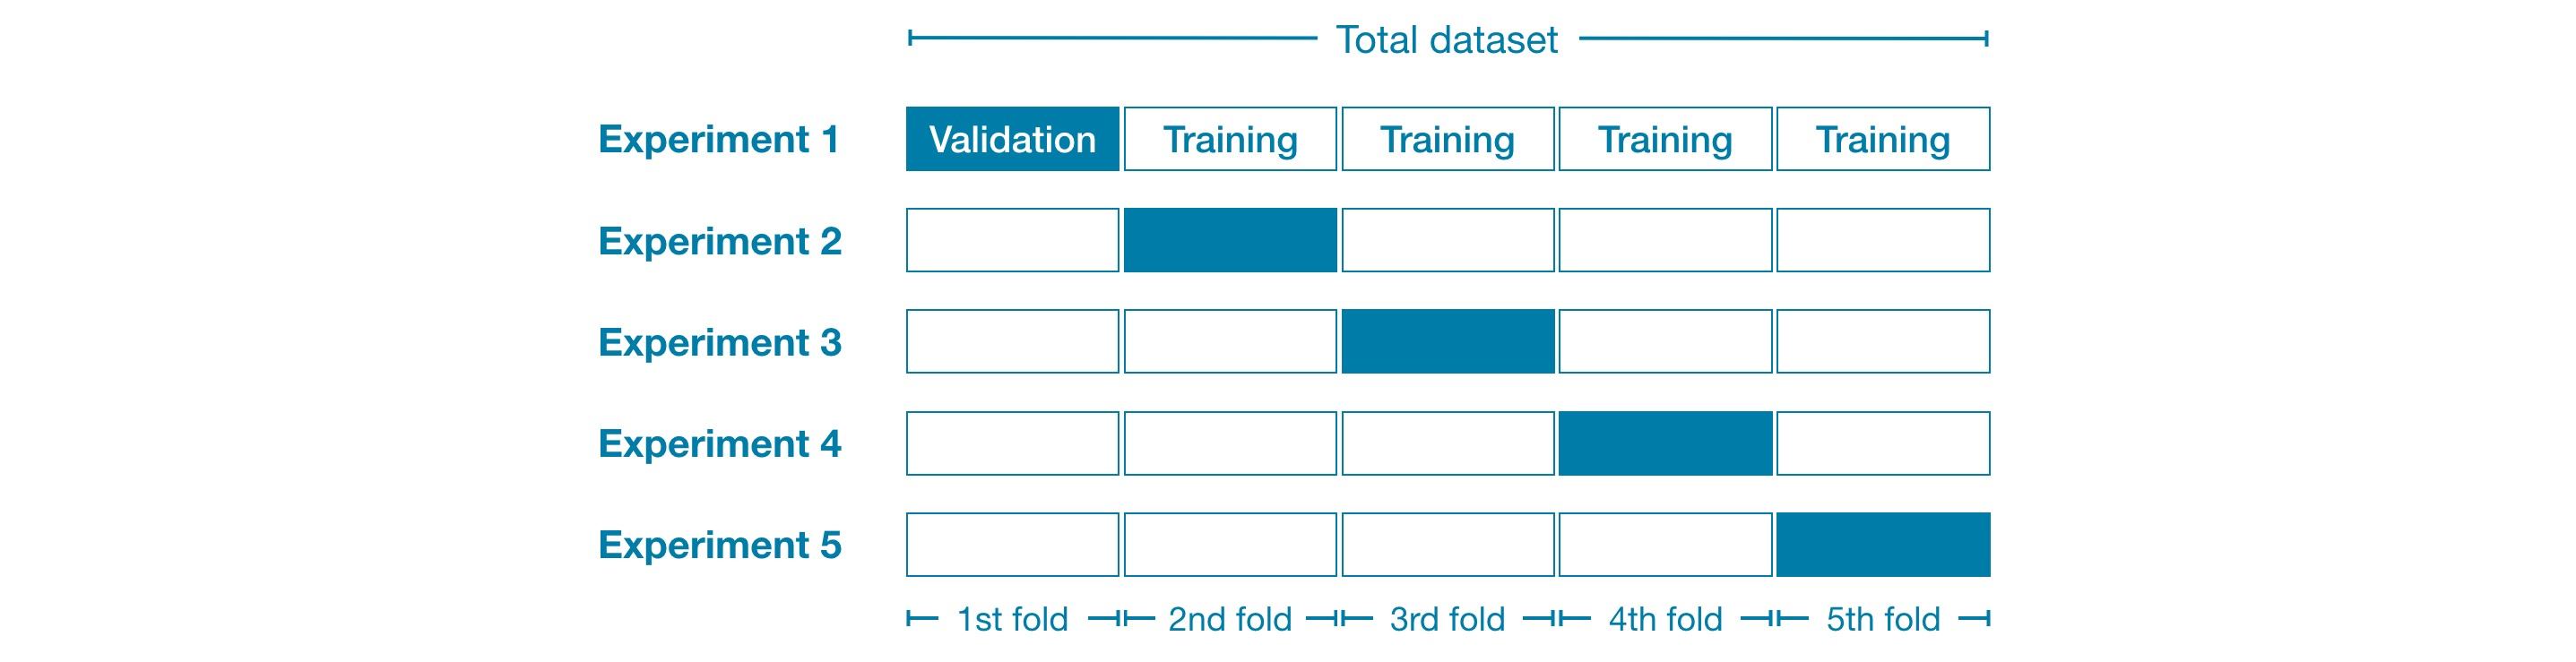

#### sklearn.model_selection 모듈의 .cross_val_score 사용

## L-fold cross-validation (교차 검증)
1. We divide the entire data (of N samples) into L groups (of N/L samples per group)
2. Select one group for test and use all others for training
3. Measure $J \left( \theta^* ; X_{Test}, y_{test} \right)$ and $J \left( \theta^* ; X_{Train}, y_{train} \right)$
4. Repeat 2 and 3 for each group and take average on both measures!
5. Check if $ J \left( \theta^* ; X_{Test}, y_{test} \right) >> J \left( \theta^* ; X_{Train}, y_{train} \right)$

In [13]:
#########################################################
## (2) Claasification example: Cross-validation

## Set parameters for cross-validation
NCV = 5
## Performance test
accuracies = mod_sel.cross_val_score(classifier, X, y, scoring='accuracy', cv=NCV, verbose = 2, n_jobs=4)
accuracy = 100*accuracies.mean()
print( "Accuracy(CV) via cross validation = %5.3f" % accuracy )

[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.


Accuracy(CV) via cross validation = 98.000


[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed:    1.9s finished


#### 평가결과의 요약 (혼동 행렬)

In [14]:
## Confusion matrix & performance report
y_pred = mod_sel.cross_val_predict(classifier, X, y, cv=NCV, verbose = 2, n_jobs=4)

c_mat = met.confusion_matrix(y, y_pred)
print("Confusion Matrix: ")
print(c_mat)
print("Classification Report: ")
print(met.classification_report(y, y_pred, target_names=label)) 


Confusion Matrix: 
[[48  2]
 [ 0 50]]
Classification Report: 
              precision    recall  f1-score   support

           B       1.00      0.96      0.98        50
           A       0.96      1.00      0.98        50

    accuracy                           0.98       100
   macro avg       0.98      0.98      0.98       100
weighted avg       0.98      0.98      0.98       100



[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed:    0.0s finished


In [13]:
classifier.coef_.shape

(1, 3)

## 4. 그리드 탐색을 이용한 하이퍼 파라미터 최적화

#### (1) 파라미터 그리드 설정

#### (2) sklearn.model_selection 모듈의 .GridSearchCV 사용

#### (3) 베스트 파라미터 추출

#### (4) 베스트 파라미터를 이용한 성능 (재) 평가

In [17]:
## Set parameters for cross-validation
NCV = 5

## (4) set parameter grid for classifier
param_grid = {'penalty': ['l2'],
             'C': [10, 100, 1000],
             'multi_class': ['multinomial'],
             'solver': ['lbfgs'],
             'max_iter': [2000],
            }

## (5) Search grid to find best parameters
clf = mod_sel.GridSearchCV(classifier, param_grid, cv=NCV, scoring='accuracy', verbose = 2, n_jobs=4)
clf.fit(X,y)

## (6) Get best paramter
best_param = clf.best_params_
print("Best Scroe: " + str(round(clf.best_score_*100,2)) + " with parameters ", end='' )
print(clf.best_params_)


Fitting 5 folds for each of 3 candidates, totalling 15 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  15 out of  15 | elapsed:    6.7s finished


Best Scroe: 90.63 with parameters {'C': 10, 'max_iter': 2000, 'multi_class': 'multinomial', 'penalty': 'l2', 'solver': 'lbfgs'}


## scikit-learn cool resourses 
1. classifier comparison: https://scikit-learn.org/stable/auto_examples/classification/plot_classifier_comparison.html#sphx-glr-auto-examples-classification-plot-classifier-comparison-py
2. Face recognition: https://scikit-learn.org/stable/auto_examples/applications/plot_face_recognition.html#sphx-glr-auto-examples-applications-plot-face-recognition-py
3. Comparison of solvers: https://scikit-learn.org/stable/auto_examples/linear_model/plot_sgd_comparison.html#sphx-glr-auto-examples-linear-model-plot-sgd-comparison-py
4. MNIST classification: https://scikit-learn.org/stable/auto_examples/linear_model/plot_sparse_logistic_regression_mnist.html#sphx-glr-auto-examples-linear-model-plot-sparse-logistic-regression-mnist-py
5. ROC and AUC: https://scikit-learn.org/stable/auto_examples/miscellaneous/plot_roc_curve_visualization_api.html#sphx-glr-auto-examples-miscellaneous-plot-roc-curve-visualization-api-py
6. ROC and AUC for multinomial classification: https://scikit-learn.org/stable/auto_examples/model_selection/plot_roc.html

## Homework

데이터 시각화에서 다루었던 8x8의 숫자 이미지 데이터에 대해 위 과정을 수행하고 그 결과를 보고서로 작성하여 제출하라.